# Model evaluation and Model selection

기계학습 모델들은 **parameter**의 값에 따라 성능이 달라진다.<br>
따라서 적절한 parameter값을 찾는 과정이 필요하다.<br>
먼저 parameter마다 **model을 평가**하고 그뒤에 그중 **가장 성능이 좋은 model을 선택**하고자 한다.

In [1]:
import sys
import warnings

In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## import

먼저 필요한 모듈들을 import한다.

In [3]:
import numpy as np
import matplotlib.pyplot as plt    
from IPython.display import Image
%matplotlib inline

sklearn의 버전을 체크하는 부분으로 제대로 install되었는지 확인한다.

In [4]:
from sklearn import __version__ as sklearn_version
from distutils.version import LooseVersion

if LooseVersion(sklearn_version) < LooseVersion('0.18'):
    raise ValueError('Please use scikit-learn 0.18 or newer')

In [5]:
sklearn_version

'0.20.2'

<br>

## DATA LOADING

**csv 데이터**를 전처리하는 과정을 알아보자.<br>
다음은 Wisconsin 유방암 데이터이다.

In [6]:
import pandas as pd # 데이터분석에 매우 유용한 모듈

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
df.shape

(569, 32)

<br>

M: Malignant - 악성<br>
B: Benign - 양성<br>
1번째 column이 **범주형(categorical)**인 것을 확인할 수 있다.<br>
따라서 이를 **수치값**으로 바꿔주어야 한다.

In [8]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [9]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

In [11]:
pd.DataFrame(y_test)[:10]

,0
0,1
1,0
2,0
3,1
4,0
5,1
6,1
7,1
8,0
9,0


<br>
<br>

## Pipeline

**Pipeline**을 통해 전처리과정과 예측모델과정을 하나의 과정으로 묶어줄 수 있다.<br>
예시에서는 **정규화+차원축소+LR** 을 한꺼번에 담고자 한다<br>
이후에 model evaluation에서 이 pipeline을 사용한다.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


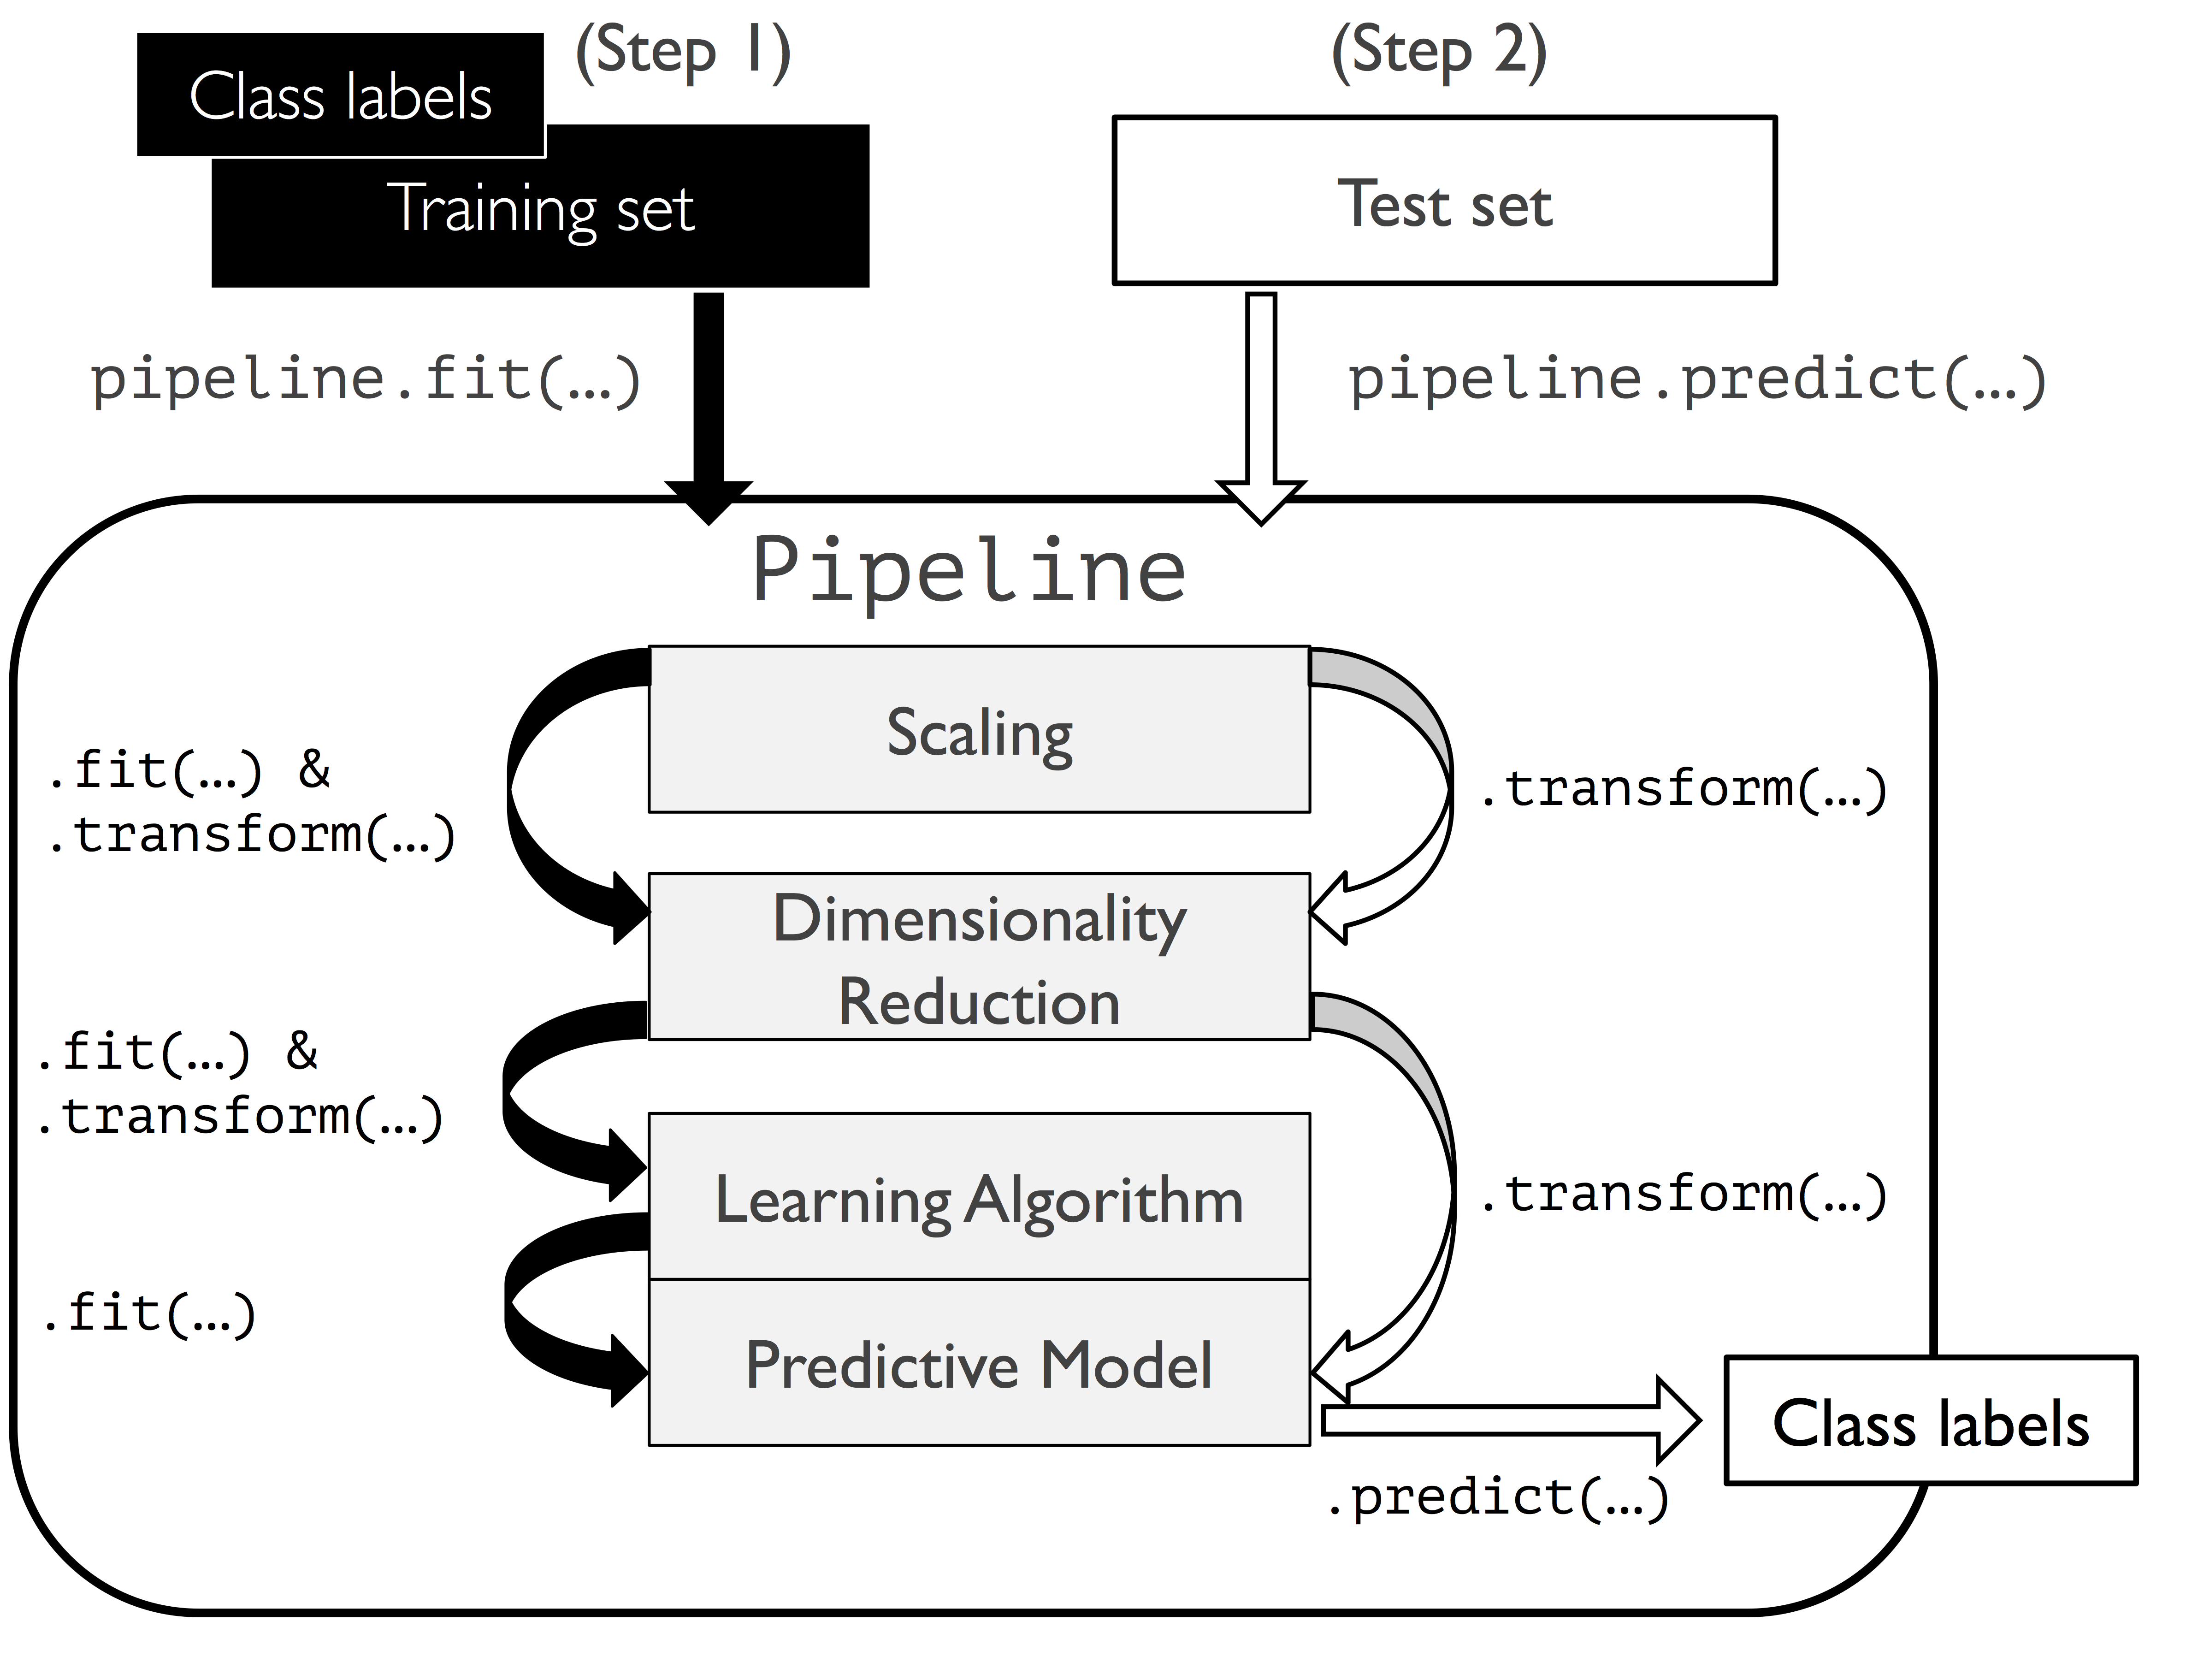

In [13]:
Image(filename='images/06_01.png', width=500) 

<br>
<br>

# k-fold 교차검증

## The holdout method

여러 parameter에 대해서 evaluation을 하는데 evaluation을 **동일한 test set**을 이용할 경우 <br>
그 test set에 **overfit**하는 model이 선택된다.<br>
마치 test set이 training에 부분적으로 사용되는 효과를 가져온다.<br>
따라서 test set이 아닌 다른 set을 이용하여 검증해야 한다. <br>
training set을 training set과 **validation set**으로 나누어 이를 해결하고자 한다.

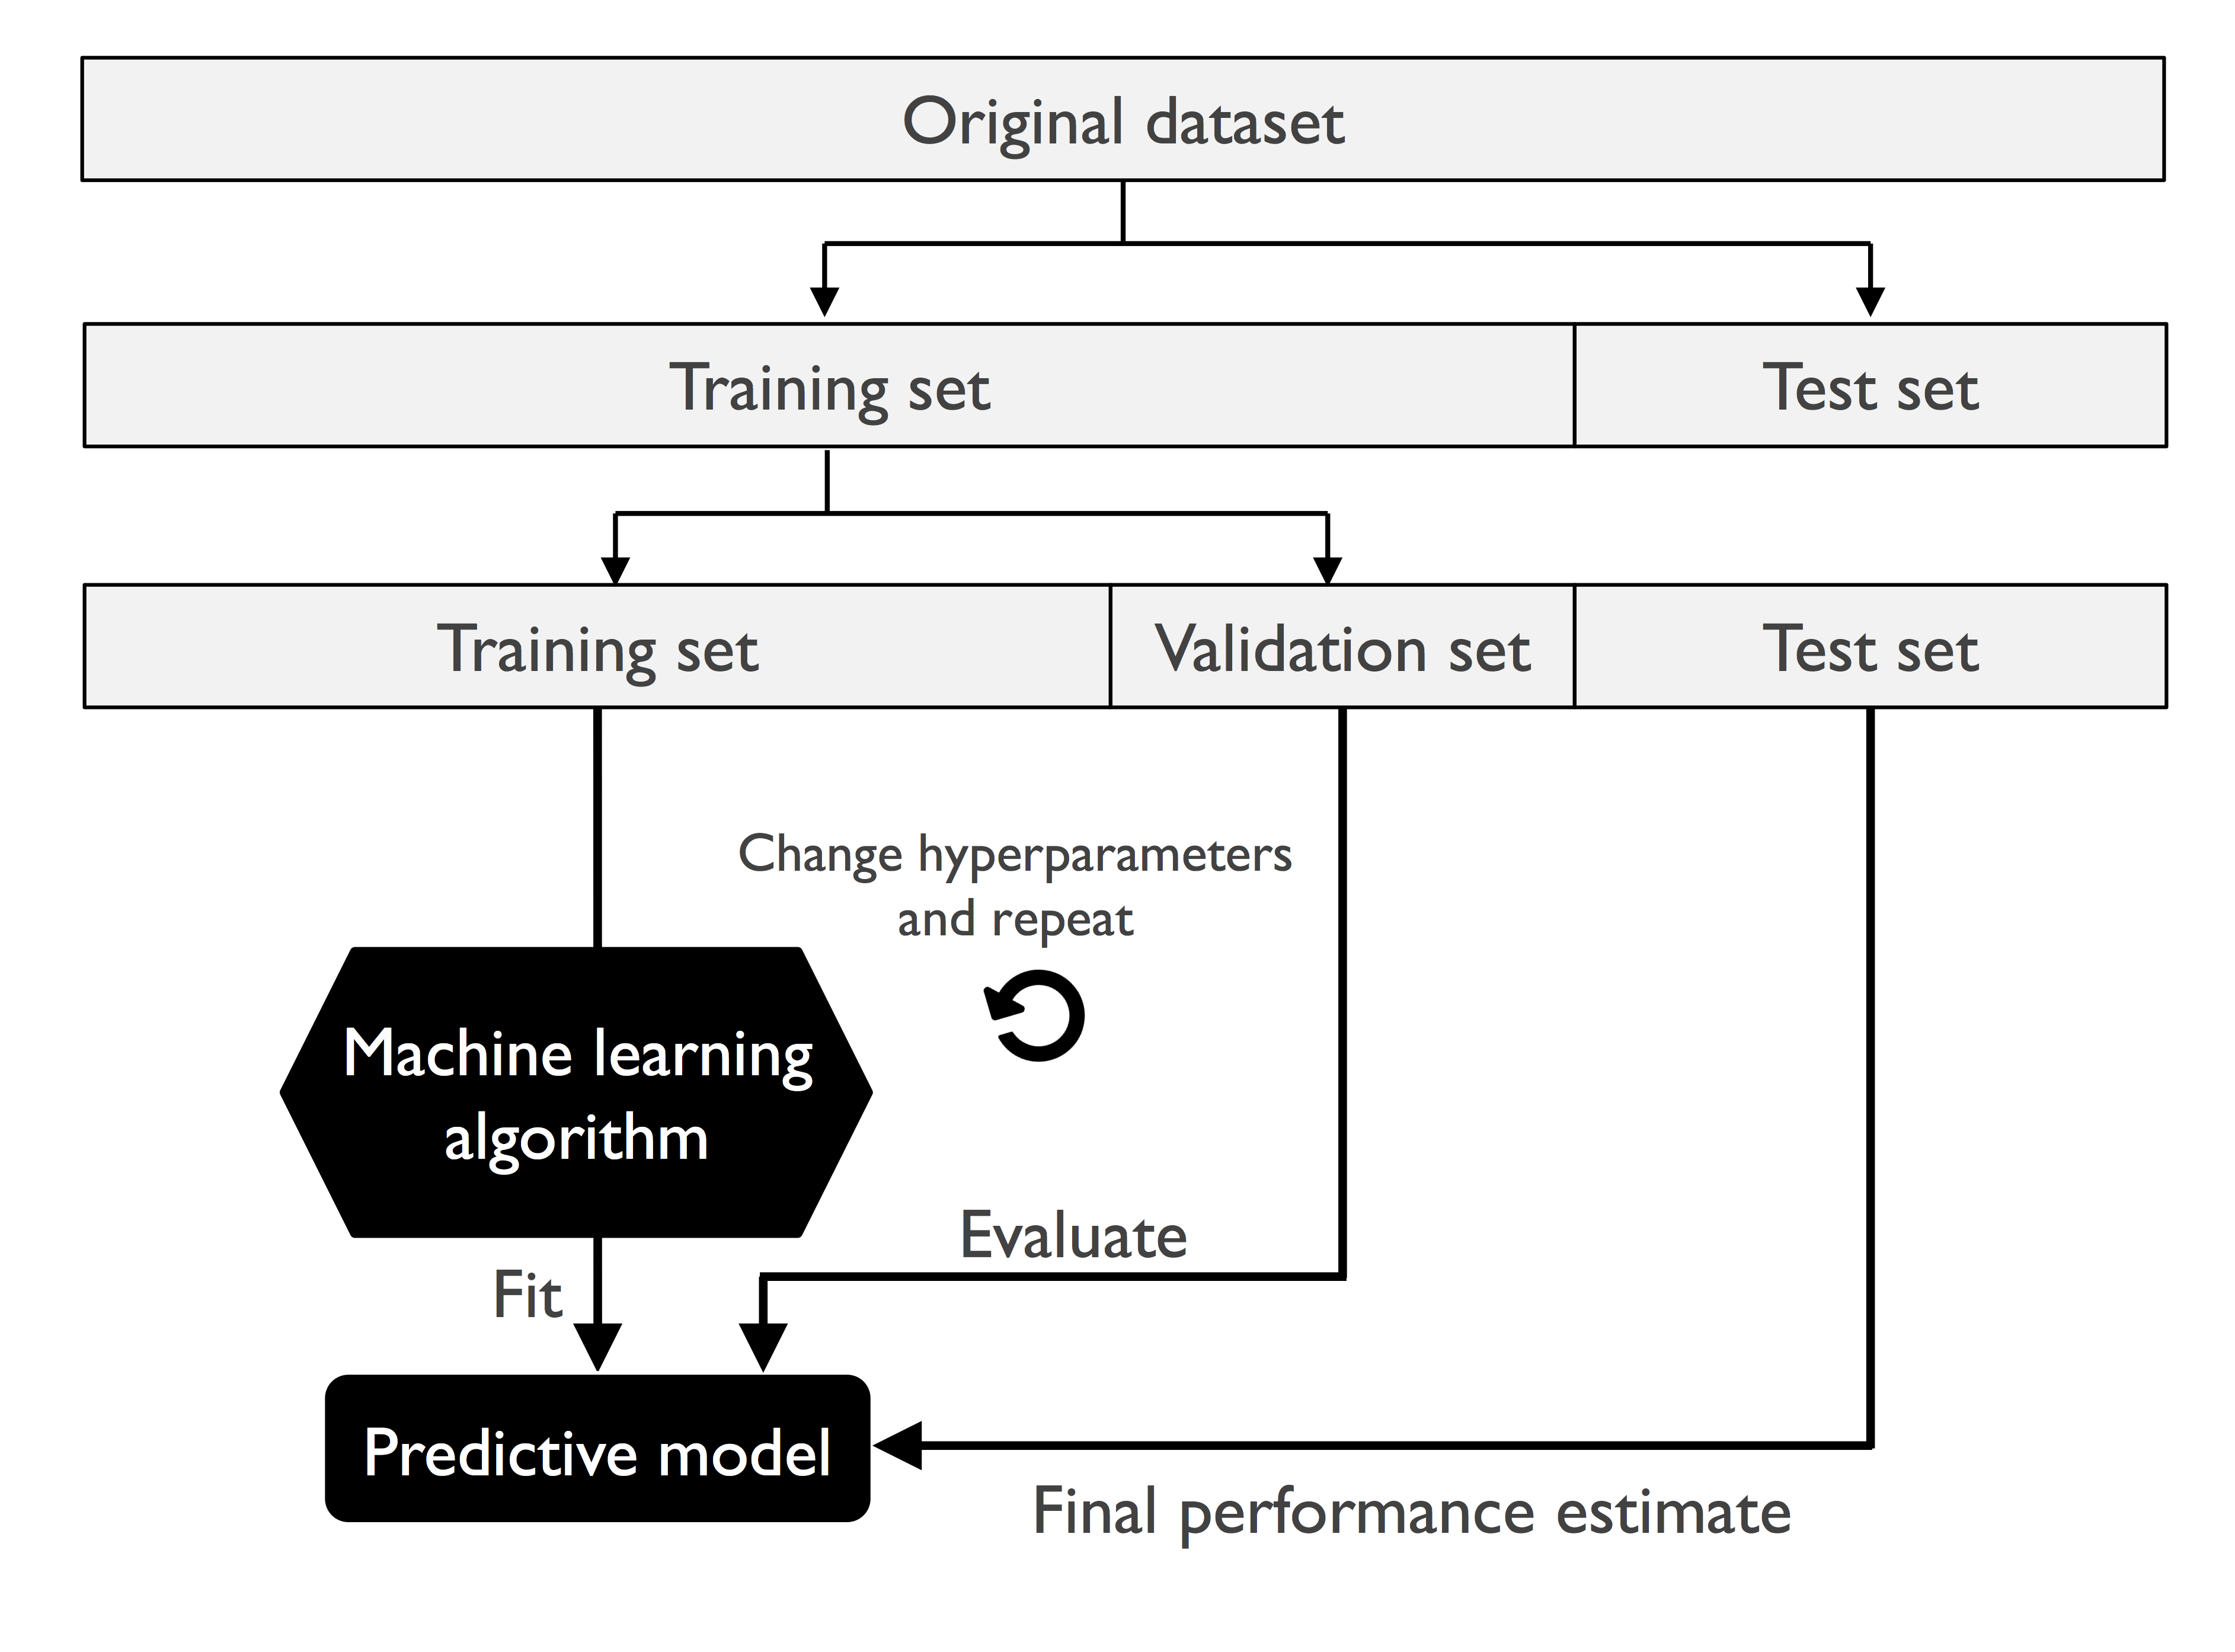

In [14]:
Image(filename='images/06_02.png', width=500) 

<br>
<br>

## K-fold cross-validation

특정 set에 overfit하는 것을 방지하기 위해 **여러 fold로 나누어** 검증하고자 한다.

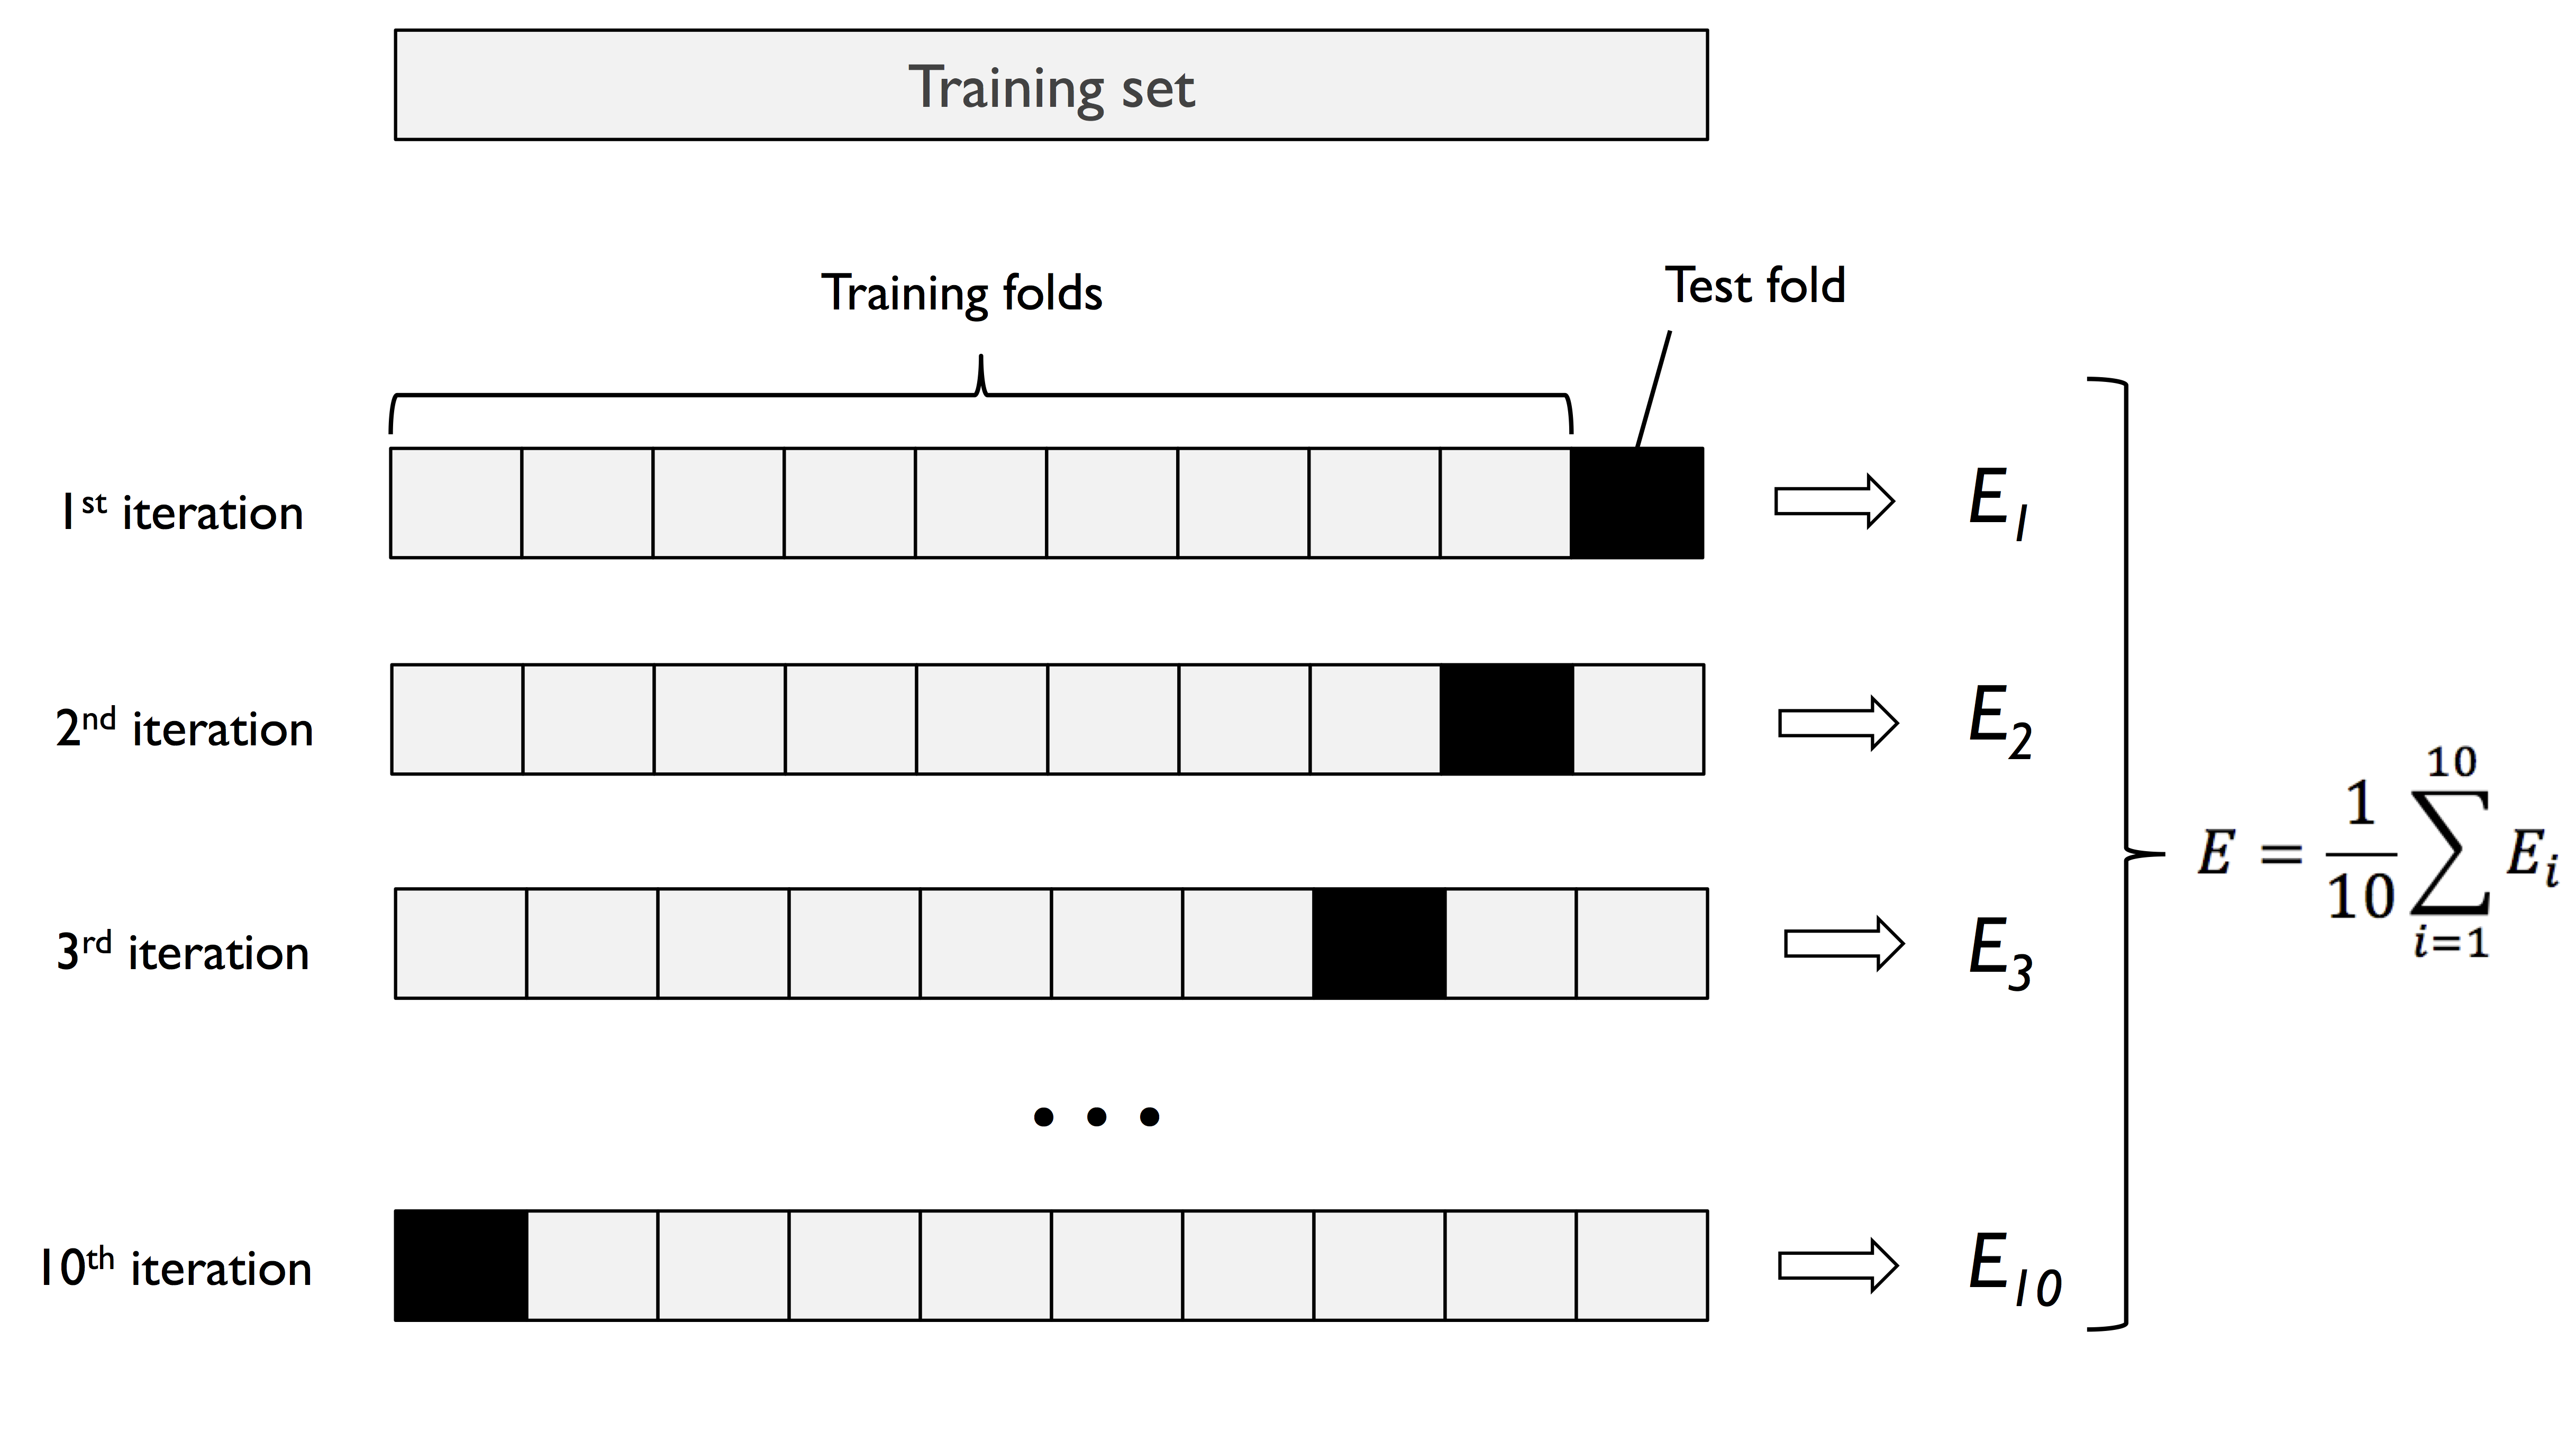

In [15]:
Image(filename='images/06_03.png', width=500) 

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


참고로 위의 cross validation은 하나의 모델(pipe_lr)에 대해서 진행된 것이다.<br>
여러 모델에 대한 비교는 위의 과정을 반복함으로써 할 수 있다.

<br>
<br>

## Validation curve

**하나**의 parameter에 대해 여러 값을 넣어가면서 비교하고자 한다.

[[0.94132029 0.93398533 0.94132029 0.93887531 0.94376528 0.94146341
  0.94146341 0.94390244 0.94146341 0.93902439]
 [0.97310513 0.97066015 0.97066015 0.96821516 0.97799511 0.97560976
  0.97317073 0.96585366 0.97073171 0.97073171]
 [0.98533007 0.98533007 0.98533007 0.98288509 0.98777506 0.98780488
  0.98780488 0.98292683 0.98536585 0.98536585]
 [0.98777506 0.98777506 0.99022005 0.99022005 0.99022005 0.9902439
  0.9902439  0.98780488 0.9902439  0.98780488]
 [0.98533007 0.98777506 0.98533007 0.99266504 0.99266504 0.9902439
  0.9902439  0.98780488 0.9902439  0.98780488]
 [0.99022005 0.99022005 0.99022005 0.99511002 1.         0.9902439
  0.9902439  0.99512195 0.99268293 0.98780488]]
Train set score :  [0.94065836 0.97167333 0.98559187 0.98925517 0.98901067 0.99218677]
Test set score  :  [0.94082126 0.97154589 0.98028986 0.98024155 0.97149758 0.95608696]


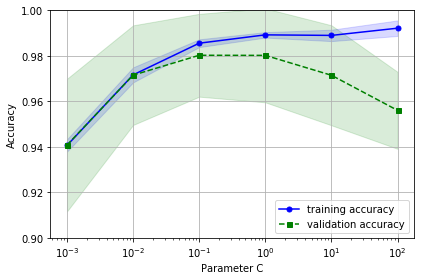

In [17]:
from sklearn.model_selection import validation_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1))

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,             ####### 비교하고자 하는 parameter의 값들
                cv=10)

print(train_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print("Train set score : ", train_mean)
print("Test set score  : ", test_mean)


plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1.0])
plt.tight_layout()
plt.savefig('images/06_06.png', dpi=300)
plt.show()

가장 validation accuracy가 높은 0.1 또는 1이 적합하다고 할 수 있다.

<br>
<br>

## Grid search

앞서의 validation curve는 하나의 parameter에 대해서 살펴보았다면<br>
grid search는 **여러 parameter의 조합**에 대해서 살펴볼 것이다.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [19]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


<br>
<br>

# 모델 성능평가 metric

## confusion matrix

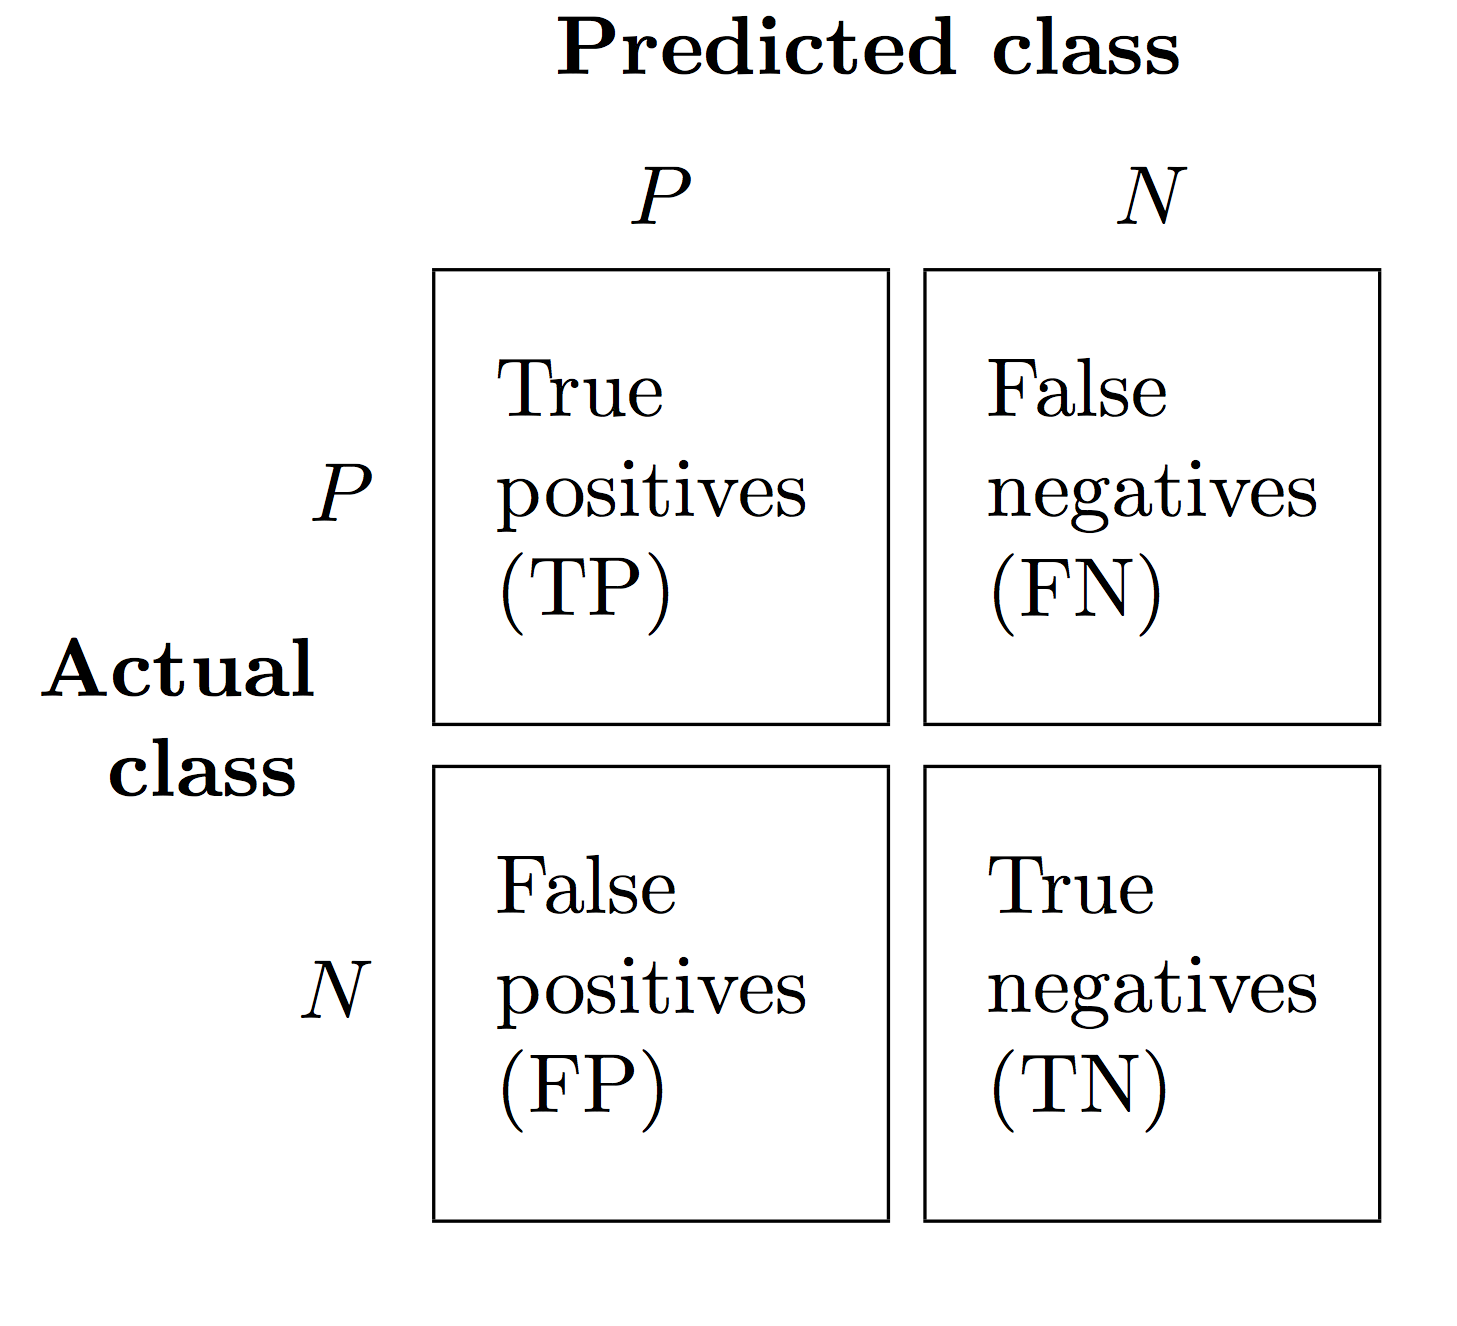

In [20]:
Image(filename='images/06_08.png', width=300) 

In [21]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


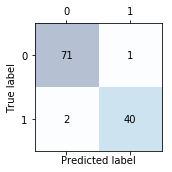

In [22]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [23]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [24]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


악성(1,M)인데 양성(0,B)으로 판단되었을 경우는 1인데 0인 경우로 False negatives, 왼쪽 아래<br>
양성(0,B)인데 악성(1,M)으로 판단되었을 경우는 0인데 1인 경우로 False positives, 오른쪽 위<br>


**의료, 보안**의 예시<br>
악성인데 아니라고 함<br>
지문이 틀렸는데 맞다고 함<br>

<br>
<br>

## 여러가지 Scorer를 이용한 평가

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [26]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9862021456964396
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [27]:
from sklearn.metrics import accuracy_score

y_pred = gs.best_estimator_.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.974


<br>
<br>

랜덤 포레스트를 이용하여 아래의 두 parameter에 대해 임의로 grid를 선정하고 f1\_score scorer를 정해서 mopdel selection을 해보자<br>
Parameters:<br>
'randomforestclassifier\_\_criterion'<br>
'randomforestclassifier\_\_n_estimators'

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
RF_scorer = make_scorer(f1_score, pos_label=0)

In [30]:
pipe_RF = make_pipeline(StandardScaler(),
                         RandomForestClassifier(random_state=1))

In [31]:
RF_param_grid = {'randomforestclassifier__criterion': ['gini', 'entropy'],
               'randomforestclassifier__n_estimators': range(10,50,10)}

In [32]:
RF_gs = GridSearchCV(estimator=pipe_RF,
                  param_grid=RF_param_grid,
                  scoring=RF_scorer,
                  cv=10,
                  n_jobs=-1)

In [33]:
RF_gs = RF_gs.fit(X_train, y_train)

In [34]:
from sklearn.metrics import accuracy_score

y_pred = RF_gs.best_estimator_.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.947
